# Pytorch Workflow

A typical pytorch workflow (one of many) :
1) Get the data ready (turn into tensors)
2) Use Pytorch to build or pick a pretrained model 
   2.1) Pick a loss funaction and optimizer
   2.2) Build a training loop
3) Fit the model to the data and make a prediction
4) Evaluate the model
5) Imporve it through experimentation
6) Save and reload the trained model

# Preparing and loading the data
 
Machine learning is a game of 2 parts :
1) Get data into numerical represenation
2) Build a model to learn the patterns in that numerical representation
 
To showcase this lets create some **known** data using the linear regression formula 

We will use a linear regression formula to make a straight line with **known** parameters 

Linear regression formula : **Y = a * X + b**

In [74]:
import torch
#create **known** parameters 
weight=0.7
bias=0.3

start=0
end=1
step=0.02

#input
X= torch.arange(start,end, step).unsqueeze(dim=1)

#ideal output
Y= weight * X + bias

X[:10], Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [75]:
#list named parameters
#model_0.state_dict()

In [76]:
#Split data into training and test sets
train_split=int(0.8* len(X))
x_train, y_train = X[:train_split], Y[:train_split]
x_test,y_test = X[train_split:], Y[train_split:]

len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

In [77]:
#visualize data using matplotlib
import matplotlib.pyplot as plt
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=None) :
    """
      plots training, test data and compares predictions
    """
    plt.figure(figsize=(10,7))
    
    #plot training data in blue
    plt.scatter(train_data, train_labels, c="b", label="Training data")
    
    #plot testing data in red
    plt.scatter(test_data, test_labels, c="r", label="Testing data")
    
    #plot predictions if they exist 
    if predictions is not None : 
        plt.scatter(test_data, predictions, c="g", label="Predictions")
        
    
    #plot the legend 
    plt.legend(prop={"size":14})
    

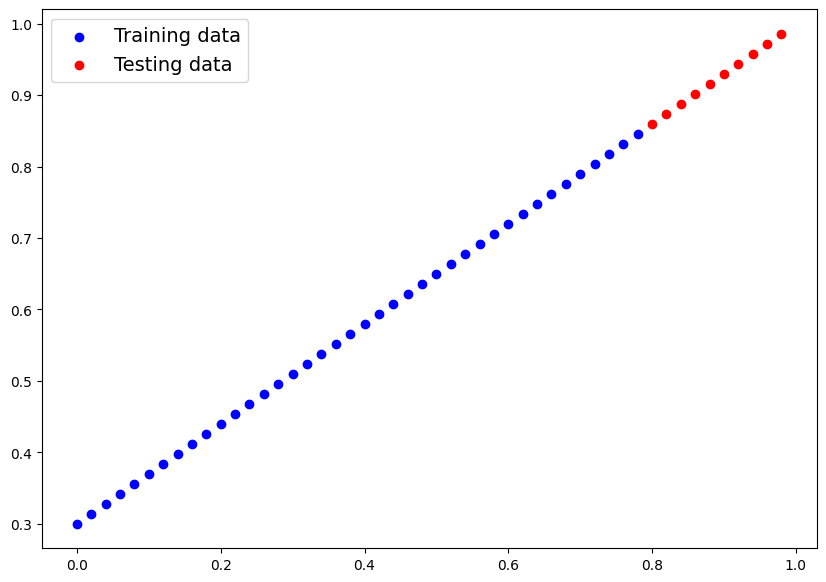

In [78]:
plot_predictions()

## Building a PyTorch model note
reference on how python classes work : https://realpython.com/python-classes/

In [79]:
#Create a Linear Regression Model class
from torch import nn
import torch
class LinearRegressionModel(nn.Module) :## almost everything in python inherits from nn.Module
    #create a constructor
    def __init__(self):
        super().__init__()
        # we use gradient descent to update the parameters 
        self.weights=nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float)) 
        self.bias=nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float))

    #add a forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor : # x is the input 
        return self.weights*x + self.bias # this is the linear regression formula 

# How this works

The function will take random values for weights and bias and will keep adjusting them and recalculate the linear regression formula over and over in order to represent the known parameters we created earlier (weight=0.7, bias=0.3) 

It does this with the use of the following 2 algorithms :
1) Gradient descent - https://youtu.be/IHZwWFHWa-w?si=UKj8ngYteq5gxuCz
2) Backpropagation - https://youtu.be/Ilg3gGewQ5U?si=uxSeiuym7XafyhJk

# PyTorch model building essentials :

* torch.nn -> contains all the tools necessary for computational graphs (a general term to describe a neural network)
* torch.nn.Parameter -> defines the parameters our model should try and learn
* torch.nn.Module -> the base class for all neural network modules
* torch.optim -> utilizies optimizers, which help with gradient descent
* def forward() -> all nn.Module subclasses require us to overwrite forward(), this mehod defines what happens in the forward computation

PyTorch cheat sheet : https://pytorch.org/tutorials/beginner/ptcheat.html 

In [80]:
# lets look whats inside our model 

#create a manual seed to control the randomness
torch.manual_seed(42)

#create an instance of the model we created
model_0=LinearRegressionModel()

#check the parameters of the instance 
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [81]:
#make predictions with  model using inference mode
#alteratively torch.no_grad() instead of inference_mode produces similar result 

with torch.inference_mode():
    y_preds=model_0(x_test)
    
y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

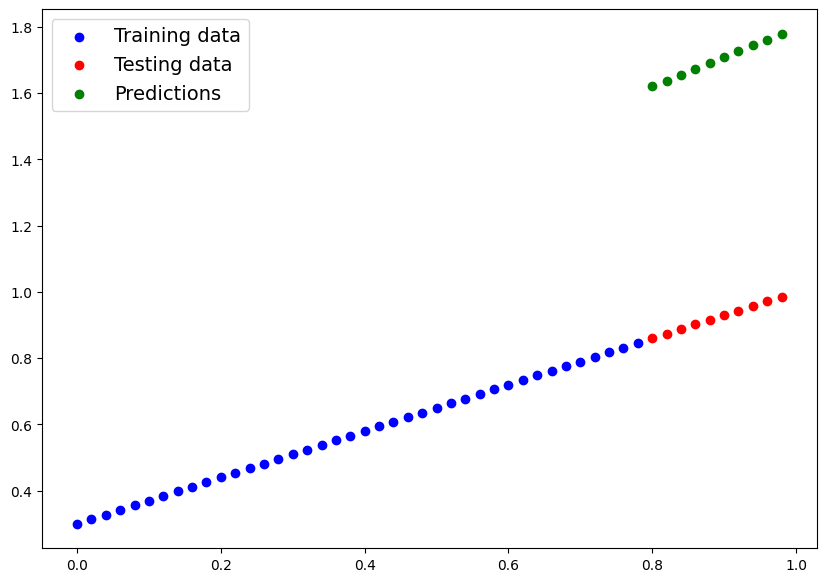

In [82]:
#visualize results
plot_predictions(predictions=y_preds)

# Training the model to make accurate predictions

The basic idea is for a model to move form some **unknown** parameters (possiby random) to some **known parameters** or in other words from a false to a better and more accurate representation of our data

To train the model we need the following :
* Loss function -> measure how wrong are our model's predictions are compared to the ideal outputs. The lower the reuslt of
* the loss function the better.
* Optimizers -> Takes into account the loss of a model and adjusts the model's parameters.

We will also require : 
1) a training loop
2) a testing loop

Relative documentation on loss functions : https://pytorch.org/docs/stable/nn.html#loss-functions

In [83]:
import torch 
from torch import nn 

#setup a loss function. for the specific model we will be using L1Loss() function which calculates the error margin 
#by finding the Mean Average Error (MAE).
#MAE is the average mean distance between expected prediction and actual prediction for each output
#the goal is to minimize the the MAE as much as possible 
loss_fn=nn.L1Loss()

#setup an optimizer (we use stochastic gradient descend)
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.01) #lr stands for learning rate and its the most important hyperparameter we can set 

## Building a training and testing loop in PyTorch step-by-step

Loop through the data and perform the following steps
1) Forward pass to make predictions on the data -> this involves data moving through our model's *forward()* functions (there may be more than one). Commonly called **forward propagation**
2) Calculate loss -> compare forward pass labels to ground truth labels.
3) optimizer zero grad
4) Loss backward -> move backwards through the network to to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5) Optimizer step -> use the optimizer to adjust our model's parameters to try and improve the loss (**graient descend**).

In [84]:
torch.manual_seed(42)

#an epoch is one loop through the data 
epochs=100

#track different values
epoch_count=[]
loss_values=[]
test_loss_values=[]

#Loop through the data 
for epoch in range(epochs):
    #set the model to training mode 
    model_0.train() #enables all parameters that can require gradients to do so to start the process of gradient descend
    
    #forward pass
    y_pred=model_0(x_train)
    
    #calculate loss
    loss=loss_fn(y_pred, y_train)
    #print(f"Loss : {loss}")
    
    
    #optimizer zero grad
    optimizer.zero_grad()
    
    #perform backpropagation on the loss with respect to the parameers of the model 
    loss.backward()
    
    #step the optimizer to perform gradient descend
    optimizer.step() #by default how the optimizer changes will be accumulated through the loop so we have to zero them
    #print(model_0.state_dict())
    
    #set the model to testing mode
    model_0.eval() #turns off gradient tracking and different settings in our model not needed for evaluation/testing
    with torch.inference_mode():
        
        #1 forward pass
        test_pred=model_0(x_test)
        
        #2 calculate the loss
        test_loss=loss_fn(test_pred, y_test )
    if epoch%10==0 :       
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

        print(f"Epoch : {epoch} , Loss : {loss}, Test Loss : {test_loss}")
        print(model_0.state_dict())



Epoch : 0 , Loss : 0.6860889196395874, Test Loss : 0.7637526988983154
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch : 10 , Loss : 0.5708791017532349, Test Loss : 0.6290428042411804
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch : 20 , Loss : 0.45566922426223755, Test Loss : 0.4943329691886902
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch : 30 , Loss : 0.34045934677124023, Test Loss : 0.35962313413619995
OrderedDict([('weights', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch : 40 , Loss : 0.2252494841814041, Test Loss : 0.2249133139848709
OrderedDict([('weights', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch : 50 , Loss : 0.1100396141409874, Test Loss : 0.09020347893238068
OrderedDict([('weights', tensor([0.6834])), ('bias', tensor([0.4050]))])
Epoch : 60 , Loss : 0.009724985808134079, Test Loss : 0.020998019725084305
OrderedDict([('weights', tensor([0.6539])), ('bias', tenso

In [85]:
import numpy as np 
epoch_count, np.array(torch.tensor(loss_values).numpy()), test_loss_values, 

([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 array([0.6860889 , 0.5708791 , 0.45566922, 0.34045935, 0.22524948,
        0.11003961, 0.00972499, 0.00621675, 0.00278832, 0.00709595],
       dtype=float32),
 [tensor(0.7638),
  tensor(0.6290),
  tensor(0.4943),
  tensor(0.3596),
  tensor(0.2249),
  tensor(0.0902),
  tensor(0.0210),
  tensor(0.0141),
  tensor(0.0058),
  tensor(0.0075)])

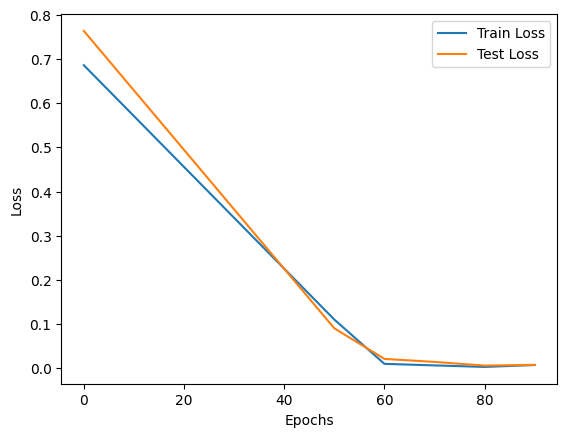

In [86]:
import matplotlib.pyplot as plt
#plot the loss curves
#convert tensors to numpy array since matplotlib works with numpy
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss" )
plt.plot(epoch_count, test_loss_values , label="Test Loss" )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


In [87]:
weight,bias

(0.7, 0.3)

In [88]:
with torch.inference_mode():
    new_y_preds=model_0(x_test)

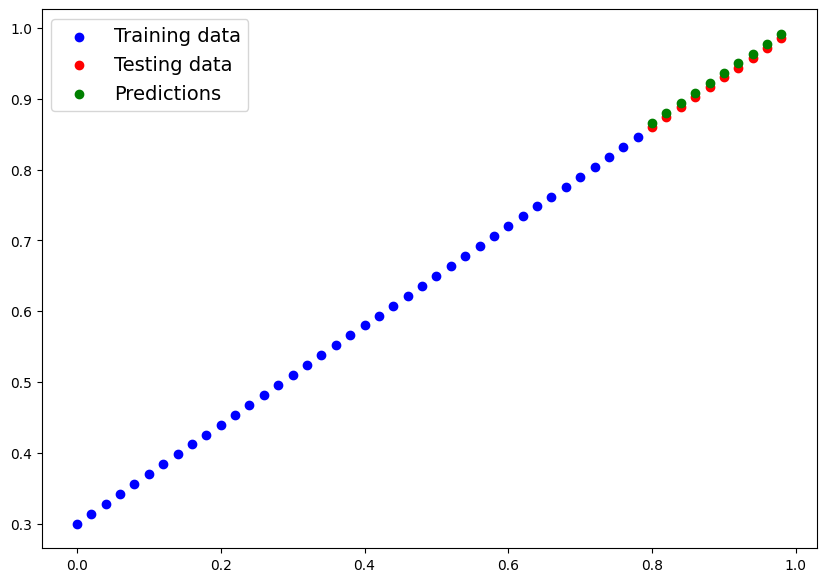

In [89]:
plot_predictions(predictions=new_y_preds)

## Saving a Model 

There are 3 methods used to save/load a model in PyTorch

1) torch.save() -> allows us to save a Pytorch object in Python's pickle format
2) torch.load() -> allows us to load a saved Pytorch object
3) torch.nn.Module.load.state_dict() -> this allows to save a model's saved state dicionary

Relative Documentation : https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [90]:
#Saving our Pytorch model 
from pathlib import Path

#create model directory
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create a model save path
MODEL_NAME="pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


#save the model state_dict
print(f"saving the model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

saving the model to : models\pytorch_workflow_model.pth


In [91]:
#in order to load a saved model's state_dict we need to instantiate a new instance of the class
loaded_model_0=LinearRegressionModel()

#load the saved state_dict of the model (this will update the model's parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [92]:
#make some predicions with loaded model 
loaded_model_0.eval() #set to test mode
with torch.inference_mode():
    loaded_model_preds=loaded_model_0(x_test)



#make predicions with original and comare to check if they match
model_0.eval() #set to test mode
with torch.inference_mode():
    original_preds=model_0(x_test)

loaded_model_preds == original_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting everything together 

An atempt to try and combine each step of the workflow by creating oen more PyTorch model example. Lets also attempt makingsome device agnostic code. This eans that if there is a GPU our code will use it for potentially faster computing. If there is not the code will default to using CPU 

In [93]:
#import pytorch and matplotlib
import torch 
from torch import nn 
import matplotlib.pyplot as plt

#create device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"using device : {device}")

using device : cpu


In [94]:
#create some data using the linear regression formula y = weights * x + bias
bias=0.3
weight=0.7

#create range values
start=0
end=1
step=0.02

#create features and labels (X and y)
X=torch.arange(start, end, step).unsqueeze(dim=1) #without unsqueeze errors will pop up

y=weight* X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [95]:
#Split the data into training and testing samples
x_train, y_train = X[:train_split], Y[:train_split]
x_test,y_test = X[train_split:], Y[train_split:]

len(x_train), len(y_train), len(y_test), len(x_test)

(40, 40, 10, 10)

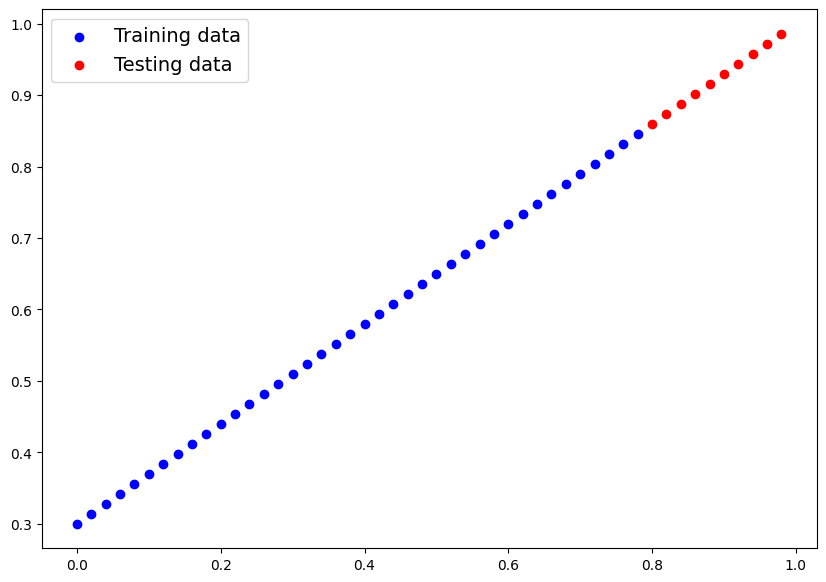

In [96]:
#plot the data 
plot_predictions(x_train, y_train, x_test, y_test)

In [97]:
#Building a PyTorch Linear model (we call it linear because it refers to a straight line)
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        #this time we use nn.Linear to create the model parameters
        #linear_layer will automatically transform our data using the linear regression formula
        self.linear_layer=nn.Linear(in_features=1,
                                    out_features=1) #this means we want to take an input of size 1 and output of size 1
    
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        return self.linear_layer(x)
        
            
#set the manual seed
torch.manual_seed(42)
model_1=LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [98]:
#check the current model device
next(model_1.parameters()).device

device(type='cpu')

In [99]:
#set the model to use the target device
#important note to remember. Everything should run on the same device so if we run the model on GPU then the data should also run in GPU
#same with cpu
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [100]:
#Training the model
#set up loss function and optimizer
loss_fn=nn.L1Loss()#same as before
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.01)


In [101]:
#Create a training loop

epochs=100

#Loop through the data 
for epoch in range(epochs):
    model_1.train() #set the mode to training mode
    
    #do the forward pass
    y_pred=model_1(x_train)
    
    #calculate the loss
    loss=loss_fn(y_pred, y_train)
    
    #optimizer zero grad
    optimizer.zero_grad()
    
    #backpropagation
    loss.backward()
    
    #step the optimizer
    optimizer.step()
    
    #Test the model 
    model_1.eval()
    with torch.inference_mode():
        #do the forward pass 
        y_test_pred=model_1(x_test)
        
        #calculate the test loss
        loss=loss_fn(y_test_pred, y_test)
        
        
    if epoch%10==0 :       
        #epoch_count.append(epoch)
        #loss_values.append(loss)
        #test_loss_values.append(test_loss)

        print(f"Epoch : {epoch} , Loss : {loss}, Test Loss : {test_loss}")
        print(model_1.state_dict())
        

Epoch : 0 , Loss : 0.5739762187004089, Test Loss : 0.005930870771408081
OrderedDict([('linear_layer.weight', tensor([[0.7606]])), ('linear_layer.bias', tensor([0.8200]))])
Epoch : 10 , Loss : 0.4392663538455963, Test Loss : 0.005930870771408081
OrderedDict([('linear_layer.weight', tensor([[0.7216]])), ('linear_layer.bias', tensor([0.7200]))])
Epoch : 20 , Loss : 0.30455657839775085, Test Loss : 0.005930870771408081
OrderedDict([('linear_layer.weight', tensor([[0.6826]])), ('linear_layer.bias', tensor([0.6200]))])
Epoch : 30 , Loss : 0.16984674334526062, Test Loss : 0.005930870771408081
OrderedDict([('linear_layer.weight', tensor([[0.6436]])), ('linear_layer.bias', tensor([0.5200]))])
Epoch : 40 , Loss : 0.03513689711689949, Test Loss : 0.005930870771408081
OrderedDict([('linear_layer.weight', tensor([[0.6046]])), ('linear_layer.bias', tensor([0.4200]))])
Epoch : 50 , Loss : 0.04784906655550003, Test Loss : 0.005930870771408081
OrderedDict([('linear_layer.weight', tensor([[0.5872]])), (

In [102]:
#compare results
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

In [103]:
weight, bias

(0.7, 0.3)

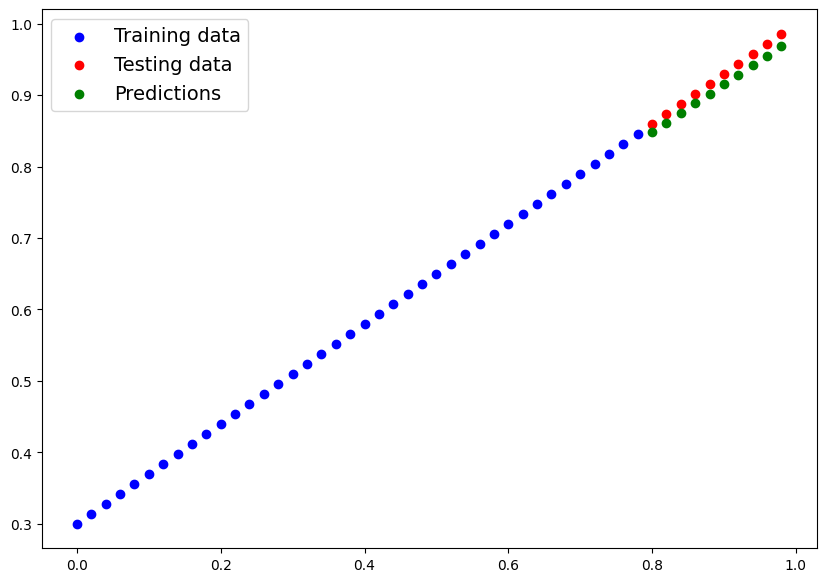

In [105]:
#make predictions and plot them
model_1.eval()
with torch.inference_mode():
    model_1_new_y_preds=model_1(x_test)
    
plot_predictions(predictions=model_1_new_y_preds)

In [106]:
#save the trained model 
#Saving our Pytorch model 
from pathlib import Path

#create model directory
MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create a model save path
MODEL_NAME="pytorch_workflow_model1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


#save the model state_dict
print(f"saving the model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

saving the model to : models\pytorch_workflow_model1.pth


In [107]:
#Load the model 
#in order to load a saved model's state_dict we need to instantiate a new instance of the class
loaded_model_1=LinearRegressionModelV2()

#load the saved state_dict of the model (this will update the model's parameters)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

In [108]:
with torch.inference_mode():
    loaded_y_preds=loaded_model_1(x_test)

loaded_y_preds==model_1_new_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])